In [466]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1181]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)

In [1182]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [428]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Consider splitting into multiple binary variables
 - PRE6 looks catagorical. As above.
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [832]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


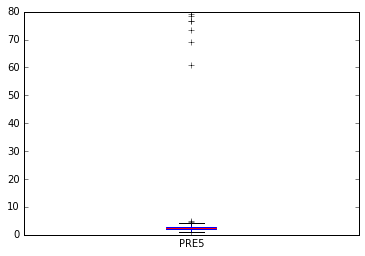

In [21]:
X.PRE5.plot(kind='box')

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors, remove outliers, and normalise the data.  

In [1184]:
from sklearn import preprocessing

def encode_onehot(x_data, column_name):
    """ Encode a catagorical column from a data frame into a data frame of one hot features"""
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(x_data[[column_name]]).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names, index=x_data.index)
    return features

def preprocess(x_data, y_data):
    # drop zero var PRE32
    Xp = x_data.drop("PRE32", axis=1)

    # remove outliers via median fill
    mask = Xp.PRE5 > 30  
    Xp.PRE5.loc[mask] = Xp.PRE5.median() 
    Yp = y_data.copy()
    
    # encode catagorical data as one hot vectors
    pre14_encoded = encode_onehot(Xp, 'PRE14')
    pre6_encoded = encode_onehot(Xp, 'PRE6')
    dgn_encoded = encode_onehot(Xp, 'DGN')

    #combine into a single data frame
    new_features = pd.concat([pre14_encoded, pre6_encoded, dgn_encoded], axis=1)

    # drop the catagorical variables that have been encoded
    Xp.drop(["PRE14", "PRE6", "DGN"], inplace=True, axis=1)
    # add new features
    Xp = pd.concat([Xp, new_features], axis=1)

    return Xp, Yp

Xp, Yp = preprocess(X, y)
Xp.head()

,PRE4,PRE5,PRE7,PRE8,PRE9,PRE10,PRE11,PRE17,PRE19,PRE25,...,PRE6_0,PRE6_1,PRE6_2,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8
0,2.08,1.52,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.36,3.76,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.52,2.28,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.36,2.67,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.56,2.80,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e5a54d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13e2f38d0>]], dtype=object)

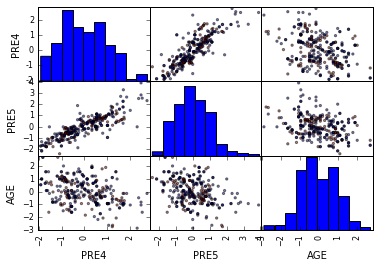

In [930]:
pd.tools.plotting.scatter_matrix(Xp[['PRE4', 'PRE5', 'AGE']], c=Yp)

## Learning

We do not have access to the labels for the final testing dataset. First split the training data into a training and validation set so we have something seperate to test on. Here we're using a  simple 80/20 split. Therefore the validation set contains 60 examples.

In [1416]:
from sklearn import cross_validation
from unbalanced_dataset import SMOTE, UnderSampler
from unbalanced_dataset.pipeline import Pipeline

def apply_smote(x_data, y_data, kind='regular'):
    sm = SMOTE(kind=kind, verbose=2)
    svmx, svmy = sm.fit_transform(x_data.as_matrix(), y_data.as_matrix())
    svmx = pd.DataFrame(svmx, columns=x_data.columns)
    svmy = pd.Series(svmy)
    svmy = svmy.astype(int)
    return svmx, svmy


Xt, Xv = cross_validation.train_test_split(Xp, test_size = 0.2, stratify=Yp)
Yt, Yv = Yp.loc[Xt.index], Yp.loc[Xv.index]

pip = Pipeline(Xt.as_matrix(), Yt.as_matrix())
Xt_smote, Yt_smote = pip.pipeline([SMOTE(kind='regular'), UnderSampler(ratio = 2)])

# Xt_smote, Yt_smote = apply_smote(Xt, Yt)

class_balance_summary(Yt)
# class_balance_summary(Yv)

(307, 26)
Determining classes statistics... 2 classes detected: {0.0: 173, 1.0: 134}
Under-sampling performed: Counter({0.0: 173, 1.0: 134})
(307, 26)
Total number of samples: 240
Number of positive samples: 67
Number of negative samples: 173
Ratio of positive to total number of samples: 0.28


## Cross Validation and ROC Analysis

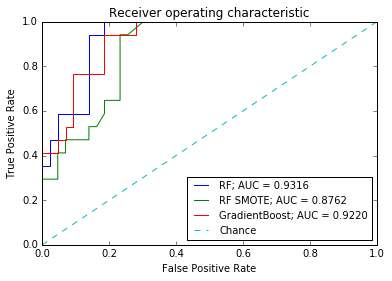

In [1417]:
from sklearn.pipeline import Pipeline
from roc_analysis import ROCAnalysisScorer
reload(roc_analysis)

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=12, subsample=0.8, min_samples_split=1)
rf = RandomForestClassifier(n_estimators=700, max_features=5)

gb_pipe = Pipeline([('scaler', scaler), ('GradientBoost', gb)])
rf_pipe = Pipeline([('scaler', scaler), ('RandomForest', rf)])

models = [
    {'name': 'GradientBoost', 'train_data': (Xt, Yt), 'test_data': (Xv, Yv), 'model': gb_pipe},
    {'name': 'RandomForest', 'train_data': (Xt, Yt), 'test_data': (Xv, Yv), 'model': rf_pipe},
    {'name': 'RandomForestSMOTE', 'train_data': (Xt_smote, Yt_smote), 'test_data': (Xv, Yv), 'model': rf_pipe}
]

def cv_pipeline(model, x_data, y_data, cv=None):
    roc_data = ROCAnalysisScorer()
    roc_data_scorer = make_scorer(roc_data, greater_is_better=True, needs_proba=True, average='weighted')
    cross_validation.cross_val_score(model, x_data, y_data, cv=cv, scoring=roc_data_scorer)
    return roc_data

def test_pipeline(model, x_data, y_data, x_test, y_test):
    model.fit(x_data, y_data)
    y_hat = model.predict_proba(x_test)

    test_result = ROCAnalysisScorer()
    test_result.auc_score(y_test, y_hat)
    return test_result
        
def score_pipelines(models, cv=None):
    results = {}
    for data in models:
        name = data['name']
        model = data['model']
        
        x_data, y_data = data['train_data']
        x_test, y_test = data['test_data']
        cv_results = cv_pipeline(model, x_data, y_data)

        test_results = test_pipeline(model, x_data, y_data, x_test, y_test)
        results[name] = (cv_results, test_results)
    return results

results = score_pipelines(models, cv=skf)

results['RandomForest'][1].plot_roc_curve(labels='RF;')
results['RandomForestSMOTE'][1].plot_roc_curve(labels='RF SMOTE;')
results['GradientBoost'][1].plot_roc_curve(labels='GradientBoost;', chance_line=True)